# Maker-Taker Game

Market making game.

Instructions:
- (Recommended) Use a virtual environment:
    - Run `python -m venv ".venv"`
    - Next, run `.venv/Scripts/activate` for Windows or `source .venv/bin/activate` for Linux/MacOS
- Install required packages: run `pip install -r requirements.txt`
- Rules of the game can be found [here](https://docs.google.com/presentation/d/1ryTI_6BcmcmYTsEhCmKehLJEeVT9DiqM6J4e1CKRdHU/edit?usp=sharing)
- Changes only need to be made within this file, `sim.ipynb`. Namely, you should overwrite the definition for `MyMaker`

In [1]:
from game import *

### Example Maker

`CenterMaker` does not use any information about what the taker chose in the previous rounds. Instead, it just quotes the maximum allowed spread around the price 5.0.

In [3]:
class CenterMaker(Maker):
    def __init__(self):
        self.contract_size = 1
        self.decision_history = []

    def receive_decision(self, decision: TakerDecision) -> None:
        self.decision_history.append(decision)

    def make_market(self, spread: float) -> (Contract, Contract):
        bid = Contract(5 - spread/2, self.contract_size)
        ask = Contract(5 + spread/2, self.contract_size)
        return bid, ask

There are two ways to test your maker: `run_one_sim` runs a single simulation.
- Passing the keyword `verbose=True` will print out information for each round.
- You can fix the true price by passing a float as the keyword `true_price`.
- The default value is `None`, in which case the true price will be randomly generated from 0.0 to 10.0.
- Returns a pair of floats: (`true_price`, `maker_profit`).

In [4]:
run_one_sim(CenterMaker(), verbose=True)

The true price is 3.94

Round 1: spread is at most 4.0
Maker bids with price=3.0, size=1
Maker asks with price=7.0, size=1
The taker SOLD at 3.0
Maker gained 0.94 this round

Round 2: spread is at most 2.0
Maker bids with price=4.0, size=1
Maker asks with price=6.0, size=1
The taker SOLD at 4.0
Maker gained -0.06 this round

Round 3: spread is at most 1.0
Maker bids with price=4.5, size=1
Maker asks with price=5.5, size=1
The taker SOLD at 4.5
Maker gained -0.56 this round


(3.941393089831391, 0.32417926949417275)

The other way to test your code is `run_many_sims`:
- The keyword `num_sims` controls how many simulations are run.
- The goal is to maximize the mean maker profit, given that the true price is uniformly distributed from 0.0 to 10.0.
- Returns a DataFrame containing summary statistics. We only care about the mean.

count    100000.000000
mean         -3.992803
std           4.335110
min         -11.499978
25%          -7.752858
50%          -4.005371
75%          -0.231077
max           3.499962
dtype: float64

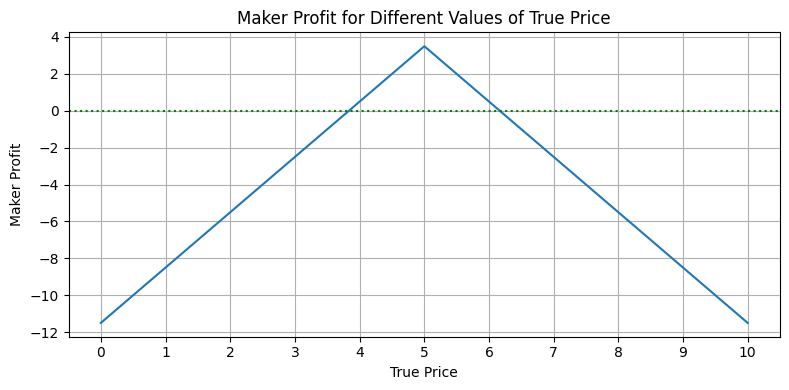

In [5]:
run_many_sims(CenterMaker, num_sims=int(1e5))

### Goal: Create a better Maker algorithm

Maximize the expected profit, i.e. the `mean` value in the DataFrame returned by `run_many_sims`.

In [6]:
# Possible idea: if the taker bought from you the first time,
# then the true value is probably higher than 5.
# So, center our market around a higher value than 5.
# Do the opposite if the taker sold to you.

class MyMaker(Maker):
    def __init__(self):
        self.bid_size = 1
        self.ask_size = 1
        self.decision_history = []

    def receive_decision(self, decision: TakerDecision) -> None:
        self.decision_history.append(decision)

    def make_market(self, spread: float) -> (Contract, Contract):
        price_estimate = 5.0
        if len(self.decision_history) > 0:
            last_decision = self.decision_history[0]
            price_estimate += last_decision.value * 2

        bid = Contract(price_estimate - spread/2, self.bid_size)
        ask = Contract(price_estimate + spread/2, self.ask_size)
        return bid, ask

In [10]:
run_one_sim(MyMaker(), verbose=False)

(5.024128834373894, -0.4758711656261063)

Indeed, the mean maker profit of this strategy is less negative than that of `CenterMaker`. But we're still losing money on average!

count    100000.000000
mean         -1.598491
std           2.666937
min          -7.499684
25%          -3.742199
50%          -0.377068
75%           0.567430
max           1.499978
dtype: float64

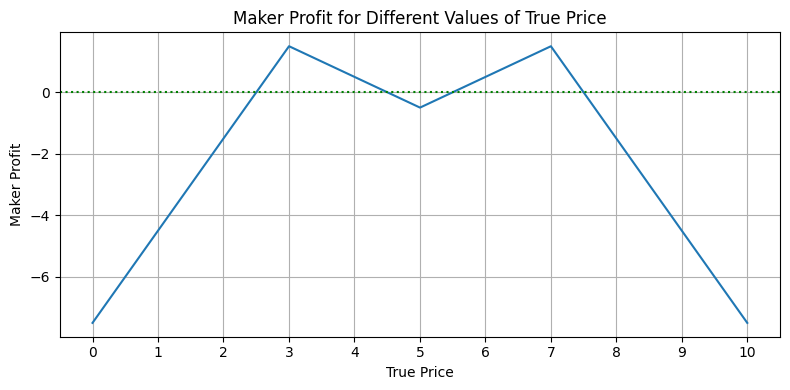

In [8]:
run_many_sims(MyMaker, num_sims=int(1e5))